# Question 1:


The dataset used is rock,paper,scissors classififcation. The dataset link to drive : https://drive.google.com/drive/folders/1lLqlna14ztVHFnd6FO7pKxI2nTQGldEQ?usp=sharing.

It has in total 312 images in total and 3 categories: rocks-108, paper-106 and scissors- 107

# 1.

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from numpy import random
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.models import load_model

In [2]:
rock_dir = "/content/drive/MyDrive/AML/img_classification_data/rock"
paper_dir= "/content/drive/MyDrive/AML/img_classification_data/paper"
scissors_dir = "/content/drive/MyDrive/AML/img_classification_data/scissors"

In [3]:
# loading images

def load_images(category_dir, category_label):
    images = []
    labels = []
    for image_name in os.listdir(category_dir):
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        image = np.array(image.resize((224, 224)))
        images.append(image)
        labels.append(category_label)
    return np.array(images), np.array(labels)

rock_images, rock_labels = load_images(rock_dir, 0)
paper_images, paper_labels = load_images(paper_dir, 1)
scissors_images, scissors_labels = load_images(scissors_dir, 2)

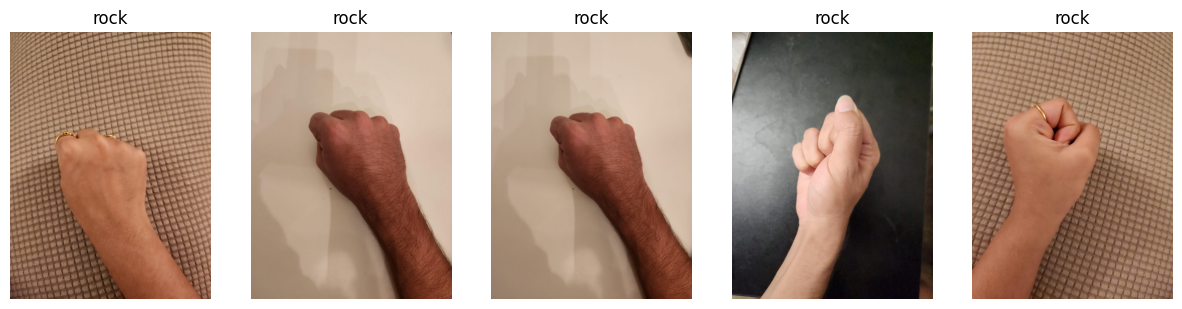

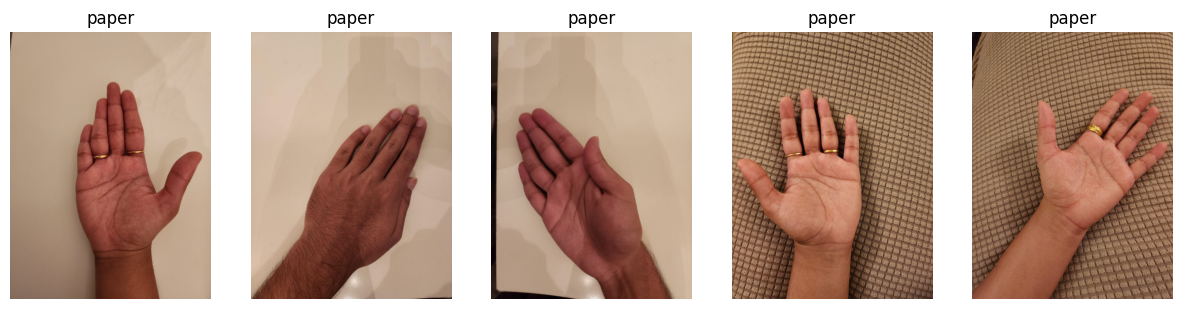

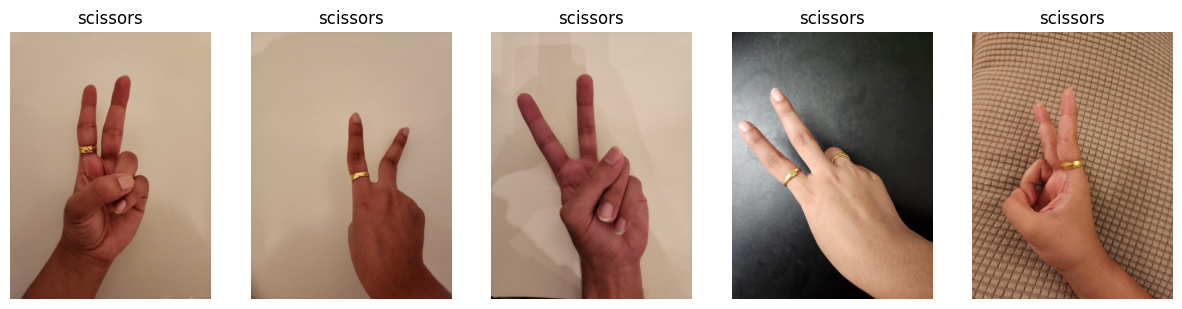

In [4]:
# 5 images of each category
categories = ["rock", "paper", "scissors"]
num_examples = 5
random_state= 59
for category in categories:
    category_dir = os.path.join("/content/drive/MyDrive/AML/img_classification_data", category)
    images = os.listdir(category_dir)

    np.random.seed(random_state)
    np.random.shuffle(images)

    fig, ax = plt.subplots(1, num_examples, figsize=(15, 5))

    for i in range(num_examples):
        image_name = images[i]
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)

        ax[i].imshow(image)
        ax[i].set_title(category)
        ax[i].axis('off')

    plt.show()

# 2.

Split the data into train , validation and test sets. 80:20 split for train and test data and split the train data again by 80:20 to create final train data and validation data respectively.

This is done by combining all three categories and then spiltting

In [5]:
all_images = np.concatenate([rock_images, paper_images, scissors_images])
all_labels = np.concatenate([rock_labels, paper_labels, scissors_labels])
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((204, 224, 224, 3), (52, 224, 224, 3), (65, 224, 224, 3))

So now we have, 204 images for training, 52 for validation and 65 for testing.

# 3.

Pipeline for Data Preprocessing and Augmentation

In [16]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen= ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator = datagen.flow(
    x= X_train,
    y= y_train,
)

validation_generator = test_datagen.flow(
    x= X_val,
    y= y_val,shuffle=False
)

test_generator = test_datagen.flow(
    x= X_test,
    y= y_test,
    shuffle=False
)

We augment the data as above and generate train , test and val generators to be passed for training the model. While doing this we shuffle only the training data and not the validation and test sets during augmentation to retain their order for evaluation.

# 4.

# Fine tuning the pre-trained model MobileNetV2

I fine tuned the last few layers of MobileNetV2 trained on the weights of ImageNet database, with my dataset for performing this classification(used 3 neurons in the Dense layer for three categories in the dataset).

The reason for choosing MobileNetV2 is due to its efficiency, speed, and adaptability to resource-constrained environments. The model strikes a balance between accuracy and computational cost, making it ideal for real-time applications on devices like mobile phones or edge devices. Its versatility, stemming from being pretrained on ImageNet, allows for effective transfer learning, especially when dealing with limited task-specific data.

In [17]:
base_model = keras.applications.MobileNetV2(input_shape=(224,224,3),
                                            include_top=False,weights ='imagenet')

Freeze the model's layers weights during training

In [18]:
for layer in base_model.layers:
  layer.trainable=False

In [19]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(train_generator,
epochs=10,
validation_data=validation_generator)

Epoch 1/10
7/7 [==============================] - 7s 566ms/step - loss: 1.0983 - accuracy: 0.5294 - val_loss: 0.6177 - val_accuracy: 0.7308
Epoch 2/10
7/7 [==============================] - 4s 551ms/step - loss: 0.5700 - accuracy: 0.7745 - val_loss: 0.3090 - val_accuracy: 0.9423
Epoch 3/10
7/7 [==============================] - 2s 337ms/step - loss: 0.3718 - accuracy: 0.8824 - val_loss: 0.1839 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 2s 324ms/step - loss: 0.2255 - accuracy: 0.9461 - val_loss: 0.1566 - val_accuracy: 0.9423
Epoch 5/10
7/7 [==============================] - 2s 316ms/step - loss: 0.2045 - accuracy: 0.9412 - val_loss: 0.0892 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 3s 414ms/step - loss: 0.1669 - accuracy: 0.9608 - val_loss: 0.0961 - val_accuracy: 0.9423
Epoch 7/10
7/7 [==============================] - 4s 592ms/step - loss: 0.1166 - accuracy: 0.9657 - val_loss: 0.0623 - val_accuracy: 1.0000
Epoch 8/10
7/7 [====

In [76]:
# saving model
model.save("/content/drive/MyDrive/AML/model")

In [39]:
model = load_model("/content/model")

Evaluate on test data

In [88]:
model.evaluate(test_generator)

3/3 [==============================] - 0s 43ms/step - loss: 0.0403 - accuracy: 0.9846


[0.04026549682021141, 0.9846153855323792]

In [87]:
model.predict(test_generator)

3/3 [==============================] - 0s 46ms/step


array([[5.3626538e-04, 9.9839956e-01, 1.0641782e-03],
       [5.1775970e-04, 9.9703777e-01, 2.4445532e-03],
       [9.4192836e-04, 9.9534971e-01, 3.7084515e-03],
       [9.8853987e-01, 1.0736577e-02, 7.2350673e-04],
       [9.9764603e-01, 2.2149412e-03, 1.3901082e-04],
       [4.4488665e-04, 9.9551153e-01, 4.0435372e-03],
       [2.2452659e-04, 4.0297289e-03, 9.9574572e-01],
       [2.5705326e-02, 9.7175431e-01, 2.5402759e-03],
       [1.2711427e-03, 4.8207819e-02, 9.5052105e-01],
       [4.0063233e-04, 1.7611315e-02, 9.8198801e-01],
       [1.0589608e-02, 9.8934877e-01, 6.1627565e-05],
       [9.8759288e-01, 1.1671174e-02, 7.3590607e-04],
       [7.7763345e-04, 1.7445767e-02, 9.8177665e-01],
       [9.9941015e-01, 5.1493495e-04, 7.4897907e-05],
       [7.9534864e-03, 9.7867167e-01, 1.3374739e-02],
       [3.9293029e-04, 1.8920669e-02, 9.8068637e-01],
       [1.2066837e-03, 9.9825984e-01, 5.3353433e-04],
       [8.3251345e-01, 1.6495495e-01, 2.5316384e-03],
       [9.9815601e-01, 1.668

 The validation accuracy is 100 percent by fine tuning MobileNet model. Training accuracy is continuously increasing and is 98.04 percent. The test accuracy is also high 98.46 percent for this dataset.

In [89]:
def predict_classifications(model, test_dataset):
    y_pred_p = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_p, axis=1)
    y_true = test_dataset.y
    correct_indices = np.where(y_pred == y_true)[0]
    incorrect_indices = np.where(y_pred != y_true)[0]
    labels = {0: "rock", 1: "paper", 2: "scissors"}

    print('Correctly classified images:')
    for i in range(min(5, len(correct_indices))):
        index = correct_indices[i]
        plt.imshow(test_dataset.x[index].astype('uint8'))
        plt.title('True label: {}, Predicted label: {}'.format(labels[y_true[index]], labels[y_pred[index]]))
        plt.show()

    print('\n\nIncorrectly classified images:')
    for i in range(min(5, len(incorrect_indices))):
        index = incorrect_indices[i]
        plt.imshow(test_dataset.x[index].astype('uint8'))
        plt.title('True label: {}, Predicted label: {}'.format(labels[y_true[index]], labels[y_pred[index]]))
        plt.show()



Displaying correctly and incorrectly classified images

3/3 [==============================] - 0s 48ms/step
Correctly classified images:


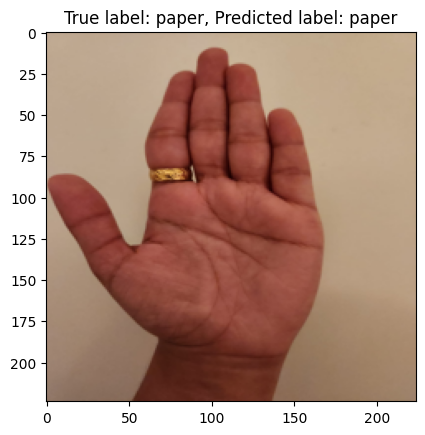

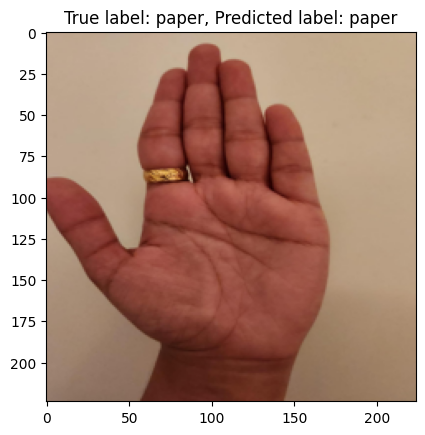

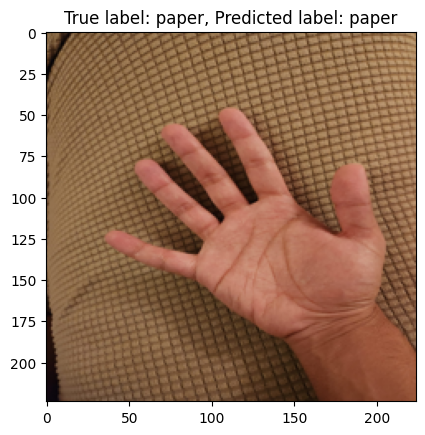

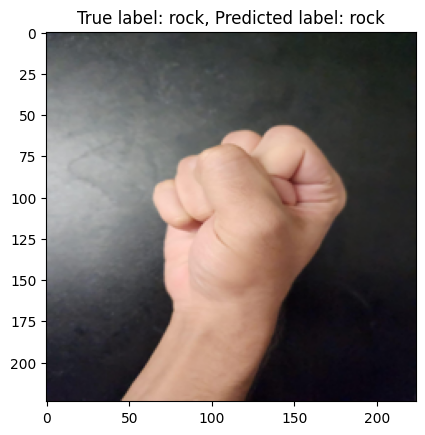

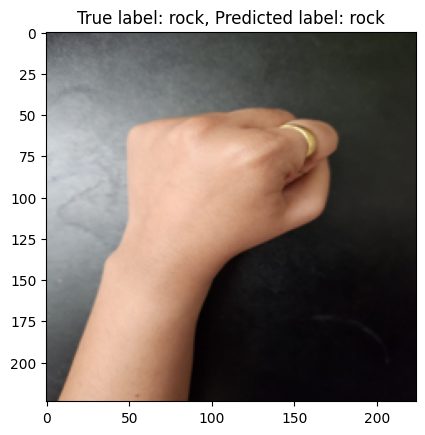



Incorrectly classified images:


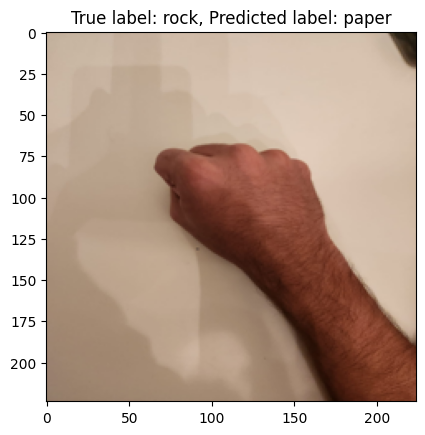

In [90]:
predict_classifications(model, test_generator)

# 5.

In [35]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(train_generator,
                    epochs= 20,
                    validation_data=validation_generator)

Epoch 1/20
7/7 [==============================] - 4s 287ms/step - loss: 1.6596 - accuracy: 0.3480 - val_loss: 1.0804 - val_accuracy: 0.3846
Epoch 2/20
7/7 [==============================] - 3s 419ms/step - loss: 1.1058 - accuracy: 0.3431 - val_loss: 1.0994 - val_accuracy: 0.3654
Epoch 3/20
7/7 [==============================] - 4s 610ms/step - loss: 1.0967 - accuracy: 0.3775 - val_loss: 1.0934 - val_accuracy: 0.3846
Epoch 4/20
7/7 [==============================] - 2s 340ms/step - loss: 1.0802 - accuracy: 0.4216 - val_loss: 1.0732 - val_accuracy: 0.4038
Epoch 5/20
7/7 [==============================] - 2s 327ms/step - loss: 1.0750 - accuracy: 0.4069 - val_loss: 1.1126 - val_accuracy: 0.2885
Epoch 6/20
7/7 [==============================] - 2s 331ms/step - loss: 1.0902 - accuracy: 0.3922 - val_loss: 1.0932 - val_accuracy: 0.3654
Epoch 7/20
7/7 [==============================] - 2s 386ms/step - loss: 1.0791 - accuracy: 0.4265 - val_loss: 1.0827 - val_accuracy: 0.3654
Epoch 8/20
7/7 [====

In [36]:
model_cnn.evaluate(test_generator)

3/3 [==============================] - 0s 24ms/step - loss: 1.0845 - accuracy: 0.4154


[1.084519386291504, 0.4153846204280853]

 The validation accuracy is 50 percent by training a CNN model from scratch. Training accuracy is continuously increasing and is 42.65 percent. The test accuracy is 41.54 percent which is lower than the pretrained model(MobileNet).

3/3 [==============================] - 0s 36ms/step
Correctly classified images:


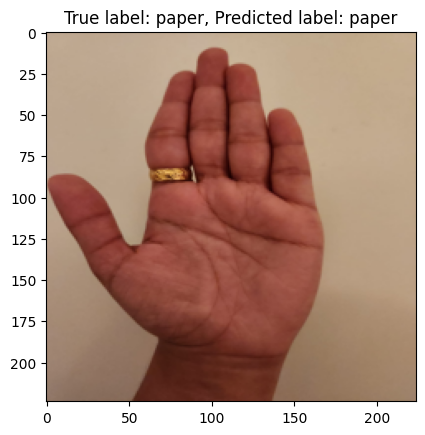

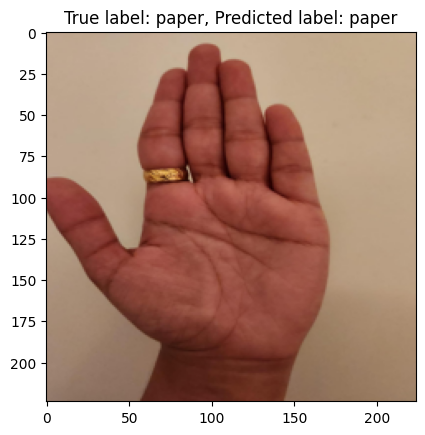

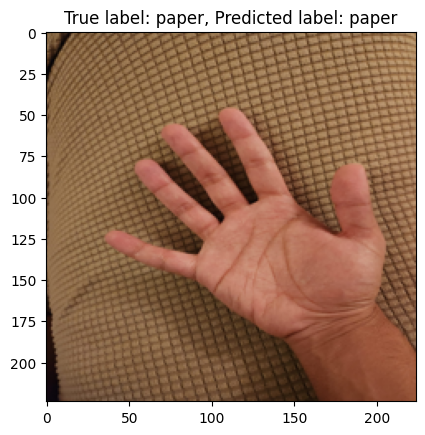

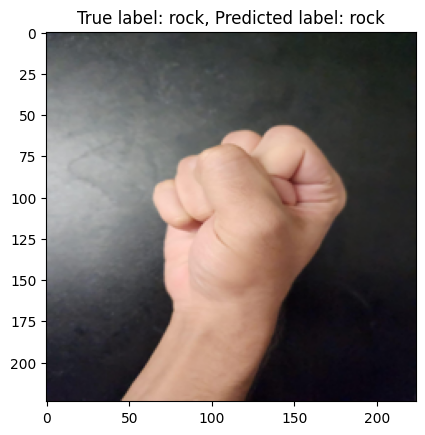

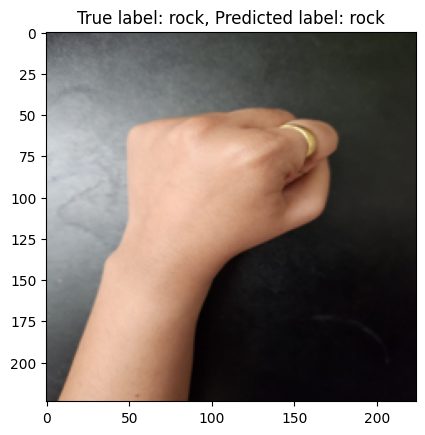



Incorrectly classified images:


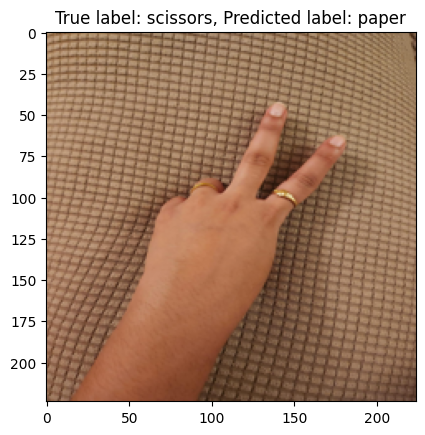

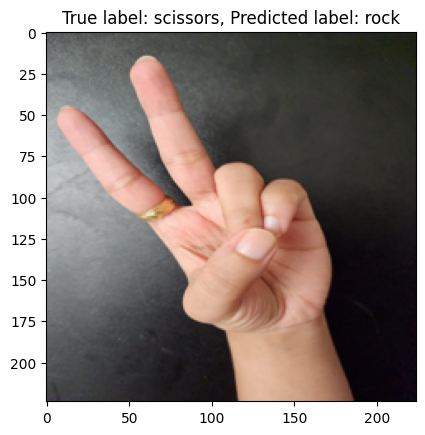

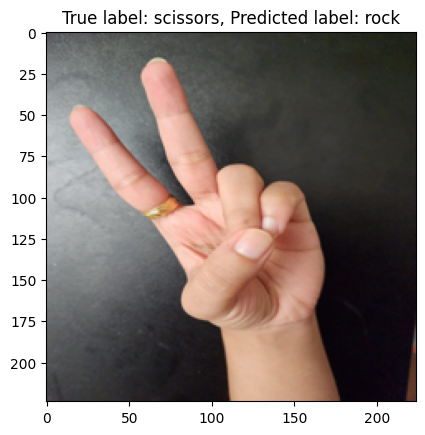

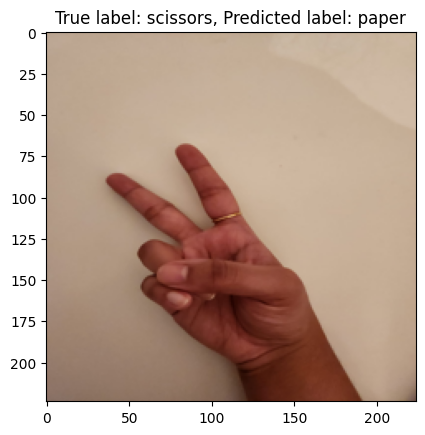

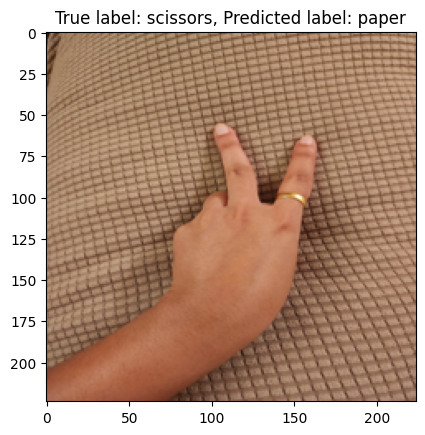

In [91]:
predict_classifications(model_cnn, test_generator)

In [75]:
# save model
model_cnn.save("/content/drive/MyDrive/AML/cnn_model")

We observe significant drop in the accuracy for the model trained from scratch as compared to the pre-trained model because the one built from scratch needs to learn the geometry and multiple factors which are already trained on the pretrained model(through its weights). Another reason is that the input dataset is not large,else it woud perform better.

This accuracy can be improved by increasing the size of dataset and also tweaking the parameter weights to get a best fit CNN model.

# References:



1.   Dataset- https://drive.google.com/drive/folders/1lLqlna14ztVHFnd6FO7pKxI2nTQGldEQ?usp=sharing
2.   https://keras.io/api/applications/mobilenet/
3. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow



